In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
train_transforms = transforms.Compose([
    # transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    # transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Loading the dataset

In [53]:
train = datasets.MNIST("/data", train=True, download=True, transform=train_transforms)
train_loader = DataLoader(train, batch_size=32, shuffle=True)

test = datasets.MNIST("/data", train=False, download=True, transform=test_transforms)
test_loader = DataLoader(test, batch_size=32, shuffle=True)

In [54]:
data = iter(train_loader)
samples,labels = next(data)
print(samples.shape, labels.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


## Plotting the image

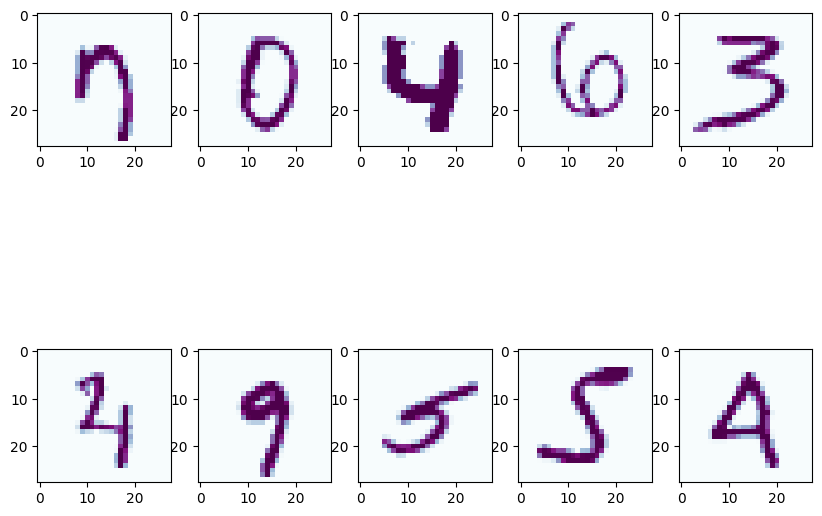

In [55]:
plt.figure(figsize=(10,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(samples[i][0], cmap="BuPu")
plt.show()

## Creating a CNN Model

In [56]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(1,14, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(14,28, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.linear_model = nn.Sequential(
            nn.Linear(28*7*7, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.linear_model(x)
        x = F.log_softmax(x, dim=1)
        return x


In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [58]:
model = Net().to(device)

In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Training the model

In [61]:
epochs = 10

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for idx , (images,labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

Epoch [1/10], Loss: 0.1586
Epoch [2/10], Loss: 0.0682
Epoch [3/10], Loss: 0.1418
Epoch [4/10], Loss: 0.0285
Epoch [5/10], Loss: 0.0247
Epoch [6/10], Loss: 0.0147
Epoch [7/10], Loss: 0.0215
Epoch [8/10], Loss: 0.0240
Epoch [9/10], Loss: 0.0140
Epoch [10/10], Loss: 0.0111


## Checking the model Accuracy

In [62]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")

check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Checking accuracy on training data
Got 59347 / 60000 with accuracy 98.91
Checking accuracy on test data
Got 9875 / 10000 with accuracy 98.75


## Predictions

In [67]:
img = images[1]
img = img.to(device)
img = img.unsqueeze(0)
print(img.shape)

with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


[5.2842197e-10 8.4483236e-12 2.7949763e-09 9.8506916e-07 2.5817785e-06
 3.2844922e-09 4.2378519e-13 4.0100904e-06 6.7929746e-09 9.9999237e-01]


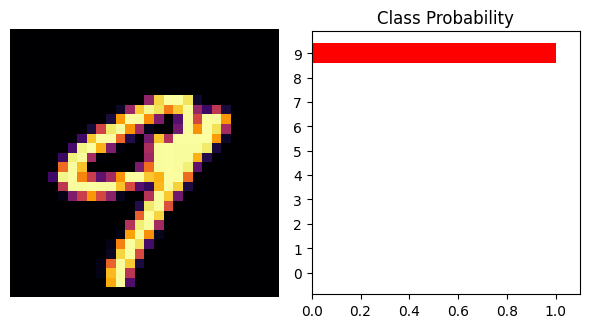

In [68]:
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

In [ ]:
# plt.plot(train_losses, label='Training loss')
# plt.plot(test_losses, label='Test loss')
# plt.legend()
# plt.grid()